In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from db import Agoda_Activities_Reviews
from db_traveloka import Activities_Reviews
from langdetect import detect
from langdetect import detect, LangDetectException
from collections import Counter

In [18]:
warnings.filterwarnings ('ignore')
pd.set_option ('display.width', None)
pd.set_option ('display.max_rows', 100)
pd.set_option ('display.max_columns', 50)

In [93]:
df = pd.read_csv ('vietnamese_reviews_dataset.csv')
df = df.drop (['Unnamed: 0', 'Author', 'Title'], axis=1)
df2 = pd.read_csv ('english_reviews_dataset.csv')
df2 = df2.drop (['Unnamed: 0', 'Author', 'Title'], axis=1)
df2

,Content,Likes,Per_Rating,Source,Time_Review,language,labels,label_type,llama_label
0,I appreciate that catering for everyone’s tast...,NaN,4/5 trên KKday,Do KKday thu thập,Nhận xét vào Tháng 4 2025 trên KKday,en,"['POS', 'POS']",same,NaN
1,"The staff was good, the buffet is quite extens...",NaN,4/5 trên KKday,Do KKday thu thập,Nhận xét vào Tháng 2 2025 trên KKday,en,"['POS', 'POS']",same,NaN
2,The buffet served onboard got lots of variety ...,NaN,5/5 trên KKday,Do KKday thu thập,Nhận xét vào Tháng 2 2025 trên KKday,en,"['POS', 'POS']",same,NaN
3,Buffet dinner was good and we enjoyed the beau...,NaN,5/5 trên KKday,Do KKday thu thập,Nhận xét vào Tháng 8 2024 trên KKday,en,"['POS', 'POS']",same,NaN
4,Seafood very fresh and nice,NaN,5/5 trên KKday,Do KKday thu thập,Nhận xét vào Tháng 7 2024 trên KKday,en,"['POS', 'POS']",same,NaN
...,...,...,...,...,...,...,...,...,...
28955,The guides were extremely helpful and friendly...,0.0,"10,0",NaN,Đánh giá cách đây 216 tuần,en,"['POS', 'POS']",same,NaN
28956,Nice services. Proud of Tinh Hoa Vietnam show,0.0,"10,0",NaN,Đánh giá cách đây 169 tuần,en,"['POS', 'POS']",same,NaN
28957,Great experience. I loved it so much.,0.0,"10,0",NaN,Đánh giá cách đây 238 tuần,en,"['POS', 'POS']",same,NaN
28958,We were able to be picked up at our own resort...,0.0,"9,0",NaN,Đánh giá cách đây 286 tuần,en,"['POS', 'POS']",same,NaN


In [62]:
df.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10076 entries, 0 to 10075
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Content      10076 non-null  object 
 1   Likes        9949 non-null   float64
 2   Per_Rating   10076 non-null  object 
 3   Source       127 non-null    object 
 4   Time_Review  10076 non-null  object 
 5   labels       10076 non-null  object 
 6   label_type   10076 non-null  object 
 7   llama_label  3197 non-null   object 
 8   label        10076 non-null  object 
dtypes: float64(1), object(8)
memory usage: 708.6+ KB


In [54]:
Missing_Value = pd.DataFrame ({
    'Missing Count' : df.isna ().sum (),
    'Missing Percentage' : df.isna ().sum () * 100 / len (df)
})
Missing_Value

,Missing Count,Missing Percentage
Content,0,0.000000
Likes,127,1.260421
Per_Rating,0,0.000000
Source,9949,98.739579
Time_Review,0,0.000000
labels,0,0.000000
label_type,0,0.000000
llama_label,6879,68.271139


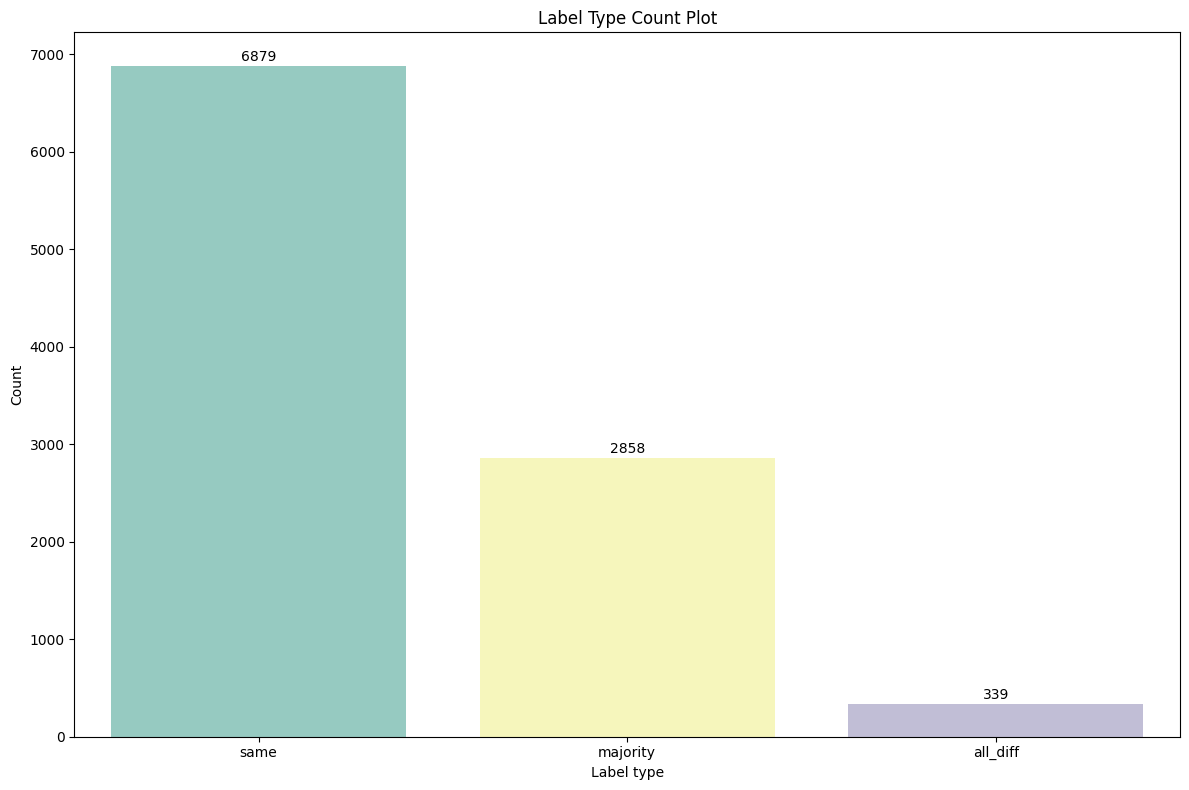

In [21]:
figure = plt.figure (figsize=(12,8))

ax = sns.countplot (x='label_type', data=df, palette='Set3')
for p in ax.patches:
    height = p.get_height ()
    ax.text (
        p.get_x () + p.get_width()/2,
        height + 50,
        int (height),
        ha='center'
    )

plt.title ('Label Type Count Plot')
plt.ylabel ('Count')
plt.xlabel ('Label type')
plt.tight_layout ()
plt.show ()

6879


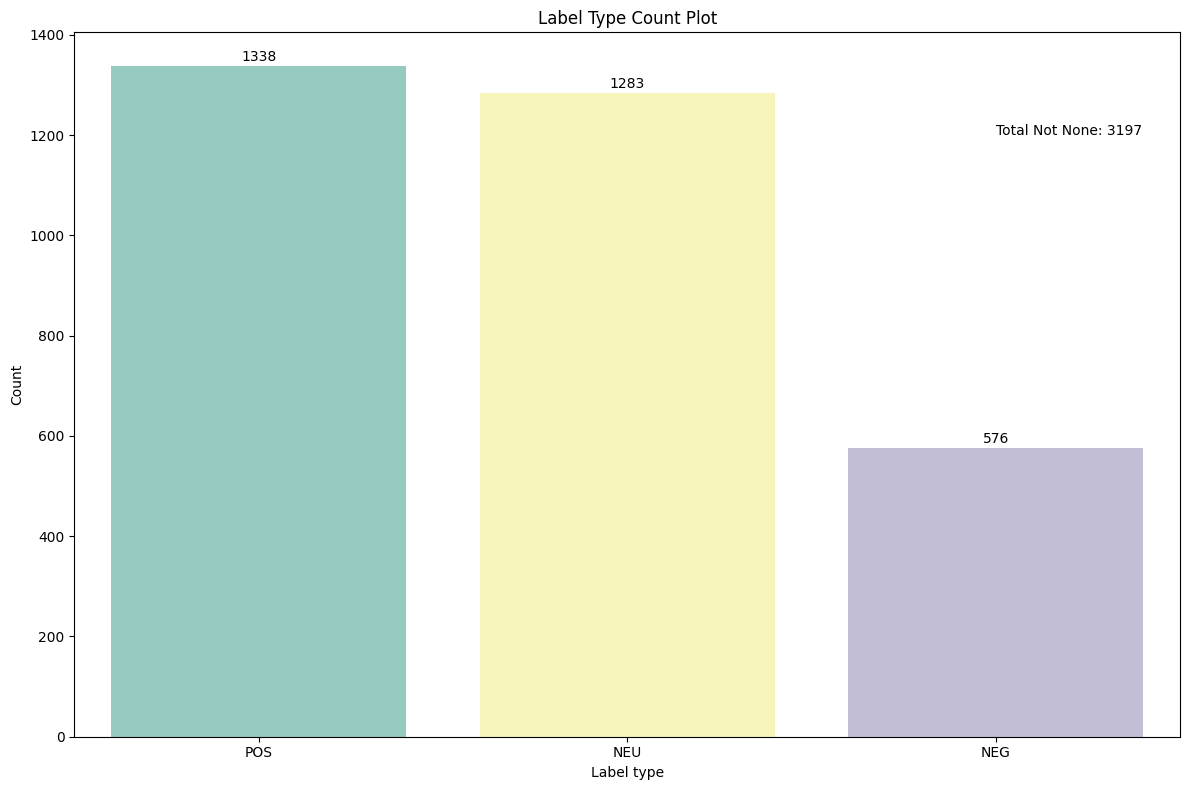

In [ ]:
figure = plt.figure (figsize=(12,8))

ax = sns.countplot (x='llama_label', data=df, palette='Set3')
for p in ax.patches:
    height = p.get_height ()
    ax.text (
        p.get_x () + p.get_width()/2,
        height + 10,
        int (height),
        ha='center'
    )

print (df['llama_label'].isna ().sum ())

plt.title ('Label Type Count Plot')
plt.text (2, 1200, f'Total Not None: {len (df) - df['llama_label'].isna ().sum ()}')
plt.ylabel ('Count')
plt.xlabel ('Label type')
plt.tight_layout ()
plt.show ()

In [94]:
def resolve_label(row):
    import ast

    # Nếu cột 'labels' là chuỗi thì chuyển về list
    labels = row['labels']
    if isinstance(labels, str):
        labels = ast.literal_eval(labels)

    labels = [x.strip().upper() for x in labels]
    unique = set(labels)

    # Nếu cả 3 nhãn giống nhau → dùng luôn
    if len(unique) == 1:
        return labels[0]

    # Ngược lại: dùng llama_label nếu có
    llama = row['llama_label']
    if pd.notna(llama):
        return llama.strip().upper()
    else:
        return "Unknown"
df['label'] = df.apply(resolve_label, axis=1)
df2['label'] = df2.apply(resolve_label, axis=1)
df2

,Content,Likes,Per_Rating,Source,Time_Review,language,labels,label_type,llama_label,label
0,I appreciate that catering for everyone’s tast...,NaN,4/5 trên KKday,Do KKday thu thập,Nhận xét vào Tháng 4 2025 trên KKday,en,"['POS', 'POS']",same,NaN,POS
1,"The staff was good, the buffet is quite extens...",NaN,4/5 trên KKday,Do KKday thu thập,Nhận xét vào Tháng 2 2025 trên KKday,en,"['POS', 'POS']",same,NaN,POS
2,The buffet served onboard got lots of variety ...,NaN,5/5 trên KKday,Do KKday thu thập,Nhận xét vào Tháng 2 2025 trên KKday,en,"['POS', 'POS']",same,NaN,POS
3,Buffet dinner was good and we enjoyed the beau...,NaN,5/5 trên KKday,Do KKday thu thập,Nhận xét vào Tháng 8 2024 trên KKday,en,"['POS', 'POS']",same,NaN,POS
4,Seafood very fresh and nice,NaN,5/5 trên KKday,Do KKday thu thập,Nhận xét vào Tháng 7 2024 trên KKday,en,"['POS', 'POS']",same,NaN,POS
...,...,...,...,...,...,...,...,...,...,...
28955,The guides were extremely helpful and friendly...,0.0,"10,0",NaN,Đánh giá cách đây 216 tuần,en,"['POS', 'POS']",same,NaN,POS
28956,Nice services. Proud of Tinh Hoa Vietnam show,0.0,"10,0",NaN,Đánh giá cách đây 169 tuần,en,"['POS', 'POS']",same,NaN,POS
28957,Great experience. I loved it so much.,0.0,"10,0",NaN,Đánh giá cách đây 238 tuần,en,"['POS', 'POS']",same,NaN,POS
28958,We were able to be picked up at our own resort...,0.0,"9,0",NaN,Đánh giá cách đây 286 tuần,en,"['POS', 'POS']",same,NaN,POS


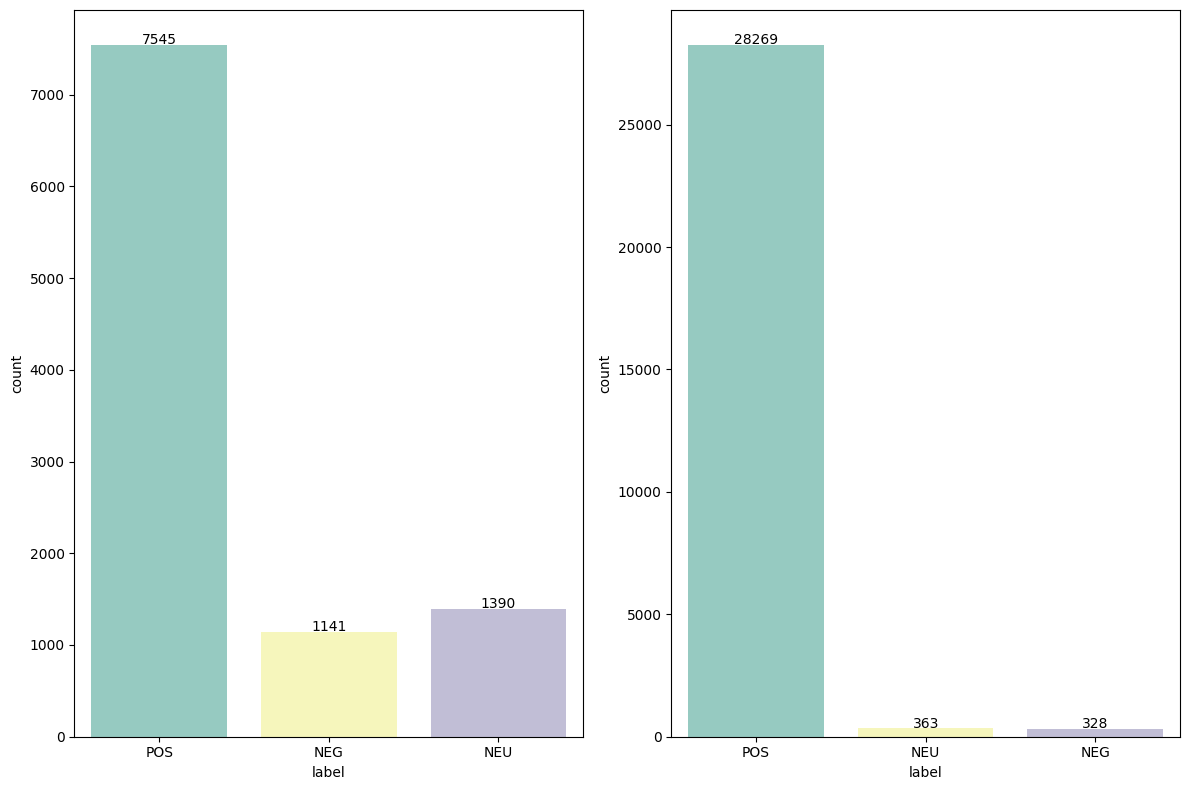

In [95]:
fig, ax = plt.subplots (1,2, figsize=(12,8))

sns.countplot (x='label', data=df, palette='Set3', ax=ax[0])
for p in ax[0].patches:
    height = p.get_height ()
    ax[0].text (
        p.get_x () + p.get_width()/2,
        height + 10,
        int (height),
        ha='center'
    )
    
sns.countplot (x='label', data=df2, palette='Set3', ax=ax[1])
for p in ax[1].patches:
    height = p.get_height ()
    ax[1].text (
        p.get_x () + p.get_width()/2,
        height + 10,
        int (height),
        ha='center'
    )

# plt.title ('Label Count Plot')
# plt.ylabel ('Count')
# plt.xlabel ('Label')
plt.tight_layout ()
plt.show ()

In [96]:
prefixes_to_exclude = [
    'dear', 'hello', 'hi', 'greetings','thanks', 'thanks for'
]

df2 = df2[
    ~df2['Content'].str.strip().str.lower().apply(
        lambda x: any(x.startswith(prefix) for prefix in prefixes_to_exclude)
    )
]


In [97]:
# Lọc các nhãn NEG và NEU
neg_neu_df = pd.concat([
    df[df['label'].isin(['NEG', 'NEU'])],
    df2[df2['label'].isin(['NEG', 'NEU'])]
])

# Lấy mẫu POS
pos_df = df[df['label'] == 'POS'].sample(n=4000, random_state=42)
pos_df2 = df2[df2['label'] == 'POS'].sample(n=3000, random_state=42)

# Gộp tất cả
final_df = pd.concat([neg_neu_df, pos_df, pos_df2], ignore_index=True)
final_df.drop (['labels', 'label_type', 'llama_label'], axis=1, inplace=True)
final_df

,Content,Likes,Per_Rating,Source,Time_Review,language,label
0,"Nhân viên không thuyết minh trên xe, mà lại đi...",NaN,1/5 trên KKday,Do KKday thu thập,Nhận xét vào Tháng 11 2019 trên KKday,vi,NEG
1,Đây là khu vui chơi mới nên tất cả còn tô...,NaN,4/5 trên KKday,Do KKday thu thập,Nhận xét vào Tháng 7 2024 trên KKday,vi,NEU
2,Rất nhiều trò chơi thú vị. nhưng phần tham qua...,NaN,5/5 trên KKday,Do KKday thu thập,Nhận xét vào Tháng 7 2024 trên KKday,vi,NEU
3,Bình thường thôi. Trẻ em thì thích,NaN,4/5 trên KKday,Do KKday thu thập,Nhận xét vào Tháng 7 2024 trên KKday,vi,NEU
4,"Xe buýt sạch sẽ, tài xế chạy an toàn. Tuy nhiê...",NaN,5/5 trên KKday,Do KKday thu thập,Nhận xét vào Tháng 9 2022 trên KKday,vi,NEU
...,...,...,...,...,...,...,...
10189,Had a really great tour with Kevin. It was rea...,NaN,4/5 trên Tripadvisor,Do Tripadvisor thu thập,Nhận xét vào Tháng 10 2022 trên Tripadvisor,en,POS
10190,Good tour with lovely people. There were four ...,NaN,4/5 trên Viator,Do Viator thu thập,Nhận xét vào Tháng 9 2023 trên Viator,en,POS
10191,Our tour guide Alex was fantastic. He was very...,NaN,5/5 trên Tripadvisor,Do Tripadvisor thu thập,Nhận xét vào Tháng 2 2025 trên Tripadvisor,en,POS
10192,"We had a great tour guided by Lucy, very infor...",NaN,5/5 trên Tripadvisor,Do Tripadvisor thu thập,Nhận xét vào Tháng 10 2019 trên Tripadvisor,en,POS


In [98]:
final_df.to_csv ('Full_Dataset_en_vi.csv')